In [1]:
from pathlib import Path
import re
import json
from math import log, ceil, floor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from tensorflow.compat.v1.train import summary_iterator
from tensorflow import make_ndarray

sns.set_theme()

2023-08-12 09:53:23.880088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 09:53:23.918094: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Functions

In [43]:
test_path = Path("./logs/ce_no_spike/setting_2/seed_1/onehot_model")

In [75]:
def get_event_path(event_dir):
    event_path_list = list(event_dir.glob("events.out.tfevents.*"))
    assert len(event_path_list) == 1, f"More than 1 event file in {str(event_dir)}"
    return event_path_list[0]

# test_train = get_event_path(test_path / "train")
# test_train

In [4]:
def get_tags(event_path):
    event_path = str(event_path)
    tags = []
    for event in summary_iterator(event_path):
        for value in event.summary.value:
            if value.tag not in tags:
                tags.append(value.tag)
                break
    return tags

# get_tags(test_train)

In [5]:
def extract_events_by_tag(event_path, tag):
    event_path = str(event_path)
    events = []
    for event in summary_iterator(event_path):
        for value in event.summary.value:
            if value.tag == tag:
                events.append(event)
                break
    return events

# extract_events_by_tag(test_train, "epoch_s_rmse")[0]

In [18]:
def event_to_df(event_path, tag):
    event_path = str(event_path)
    df_dict = {"wall_time": [], "step": [], tag: []}
    events = extract_events_by_tag(event_path, tag)
    for event in events:
        df_dict["wall_time"].append(event.wall_time)
        df_dict["step"].append(event.step)
        values = event.summary.value
        if len(values) > 1:
            print("Over 1 value in event:")
            print(event)
            return
        df_dict[tag].append(make_ndarray(values[0].tensor).tolist())
    return pd.DataFrame(df_dict)

# test_df = event_to_df(test_train, "epoch_s_rmse")
# test_df.head()

In [44]:
def extract_text_by_tag(event_path, tag):
    event_path = str(event_path)
    events = extract_events_by_tag(event_path, tag)
    values = events[0].summary.value
    if len(values) > 1:
        print("Over 1 value in event:")
        print(event)
        return
    value = values[0]
    text = make_ndarray(value.tensor).tolist()
    return text.decode("utf-8")

# test_info = get_event_path(test_path / "info")
# info_str = extract_text_by_tag(test_info, "training_setting")
# info_dict = json.loads(info_str)
# info_dict

AssertionError: More than 1 event file in this directory

### Plot for settings

In [8]:
main_path = Path("./logs/ce_no_spike/")
show_train = get_event_path(main_path / "setting_1" / "seed_1" / "onehot_model" / "train")
show_valid = get_event_path(main_path / "setting_1" / "seed_1" / "onehot_model" / "validation")
show_train_tag = get_tags(show_train)
show_valid_tag = get_tags(show_valid)
print("train tags:")
display(", ".join(show_train_tag))
print("validation tags:")
display(", ".join(show_valid_tag))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
train tags:


'epoch_loss, epoch_s_rmse, epoch_s_mae, epoch_p_acc, epoch_a_acc, epoch_c_acc, epoch_V_p_acc, epoch_D_p_acc, epoch_J_p_acc, gru_1/gru_cell_1/kernel_0/histogram, gru_1/gru_cell_1/recurrent_kernel_0/histogram, gru_1/gru_cell_1/bias_0/histogram, dense_1/kernel_0/histogram, dense_1/bias_0/histogram, dense_2/kernel_0/histogram, dense_2/bias_0/histogram, dense_3/kernel_0/histogram, dense_3/bias_0/histogram, dense_4/kernel_0/histogram, dense_4/bias_0/histogram, output/kernel_0/histogram, output/bias_0/histogram'

validation tags:


'evaluation_loss_vs_iterations, evaluation_s_rmse_vs_iterations, evaluation_s_mae_vs_iterations, evaluation_p_acc_vs_iterations, evaluation_a_acc_vs_iterations, evaluation_c_acc_vs_iterations, evaluation_V_p_acc_vs_iterations, evaluation_D_p_acc_vs_iterations, evaluation_J_p_acc_vs_iterations, epoch_loss, epoch_s_rmse, epoch_s_mae, epoch_p_acc, epoch_a_acc, epoch_c_acc, epoch_V_p_acc, epoch_D_p_acc, epoch_J_p_acc'

In [9]:
def aggregate_setting_results(setting_path, data_type, tag):
    assert data_type in ("train", "validation")
    df_all = pd.DataFrame()
    for seed in (1, 42, 100):
        seed_path = setting_path / f"seed_{seed}"
        for model_path in seed_path.glob("*_model"):
            model_name = model_path.stem
            event_dir = model_path / data_type
            event_path = get_event_path(event_dir)
            df_temp = event_to_df(event_path, tag)
            df_temp["encode"] = model_name.split("_")[0]
            df_all = pd.concat([df_all, df_temp])
    df_all.sort_values(["encode", "step"], inplace=True)
    return df_all

df_all_test = aggregate_setting_results(main_path / "setting_1", "train", "epoch_s_rmse")
df_all_test.head()

,wall_time,step,epoch_s_rmse,encode
0,1.687469e+09,0,118.991997,2mer
0,1.687472e+09,0,77.523895,2mer
0,1.687475e+09,0,93.895157,2mer
1,1.687469e+09,1,11.111797,2mer
1,1.687472e+09,1,10.560342,2mer


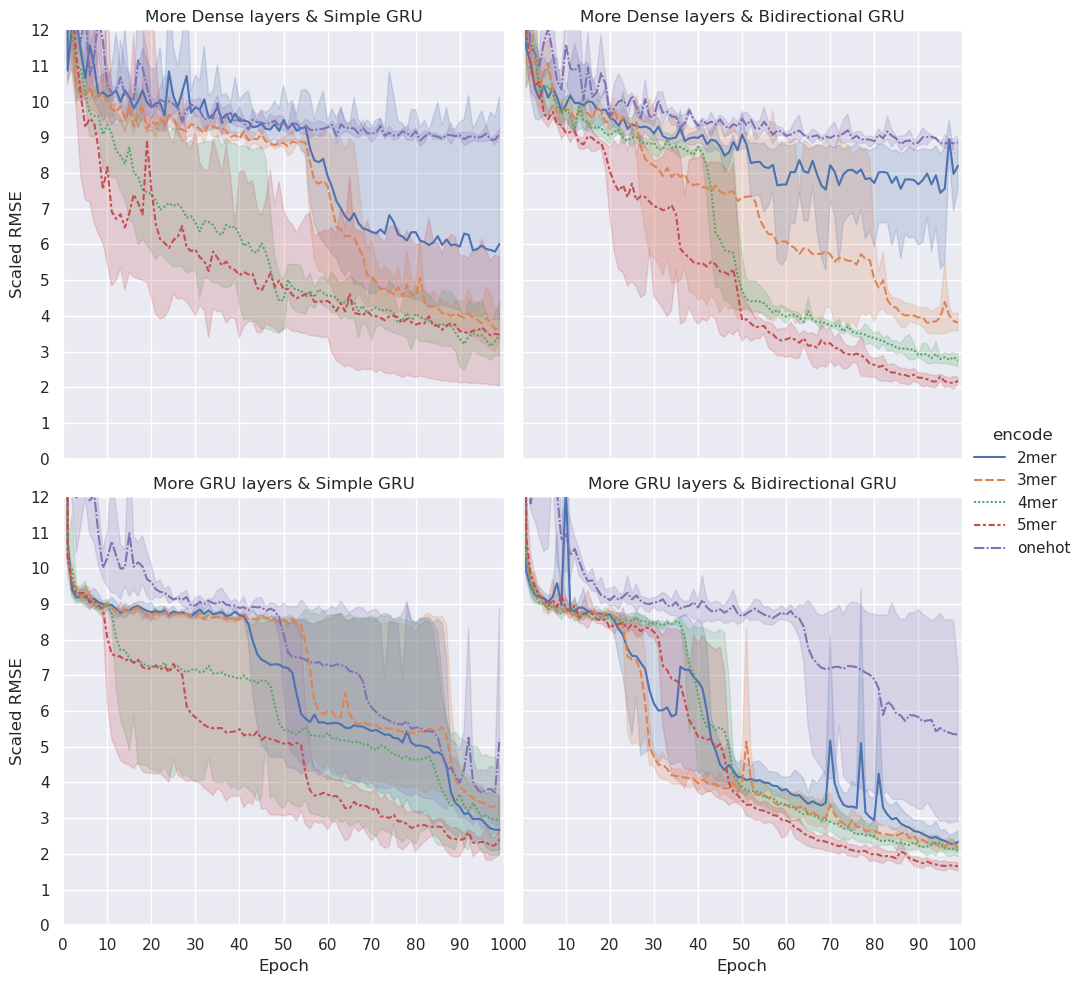

In [95]:
def plot_setting_2(ce_dir, data_type, tag, **plot_args):
    if isinstance(ce_dir, str):
        ce_dir = Path(ce_dir)
    df_plot = pd.DataFrame()
    title = {
        1: "More Dense layers & Simple GRU",
        2: "More Dense layers & Bidirectional GRU",
        3: "More GRU layers & Simple GRU",
        4: "More GRU layers & Bidirectional GRU"
    }
    for setting in (1, 2, 3, 4):
        df_new = aggregate_setting_results(ce_dir / f"setting_{setting}", data_type, tag)
        df_new["setting"] = title[setting]
        df_plot = pd.concat([df_plot, df_new])

    facet = sns.relplot(
        data=df_plot, x="step", y=tag, 
        hue="encode", style="encode", 
        col="setting", col_wrap=2,
        kind="line", **plot_args
    )
    tag2lbl = {
        "epoch_s_rmse": "Scaled RMSE"
    }
    facet.set(
        xlim=(0, 100), xticks=np.arange(0, 101, 10), xlabel="Epoch",
        ylim=(0, 12), yticks=np.arange(0, 13, 1), ylabel=tag2lbl[tag]
    )
    facet.set_titles("{col_name}")
    # suptitle = data_type + "ing" if data_type == "train" else data_type
    # facet.fig.subplots_adjust(top=0.7)
    # facet.fig.suptitle(f"Performance of different encoding methods on the {suptitle} set")
    # facet.tight_layout()
    return facet

facet = plot_setting_2("./logs/ce_no_spike/", "train", "epoch_s_rmse")
plt.savefig(f"./plots/comparisons_train_ce_no_spike_2.png")
plt.show()

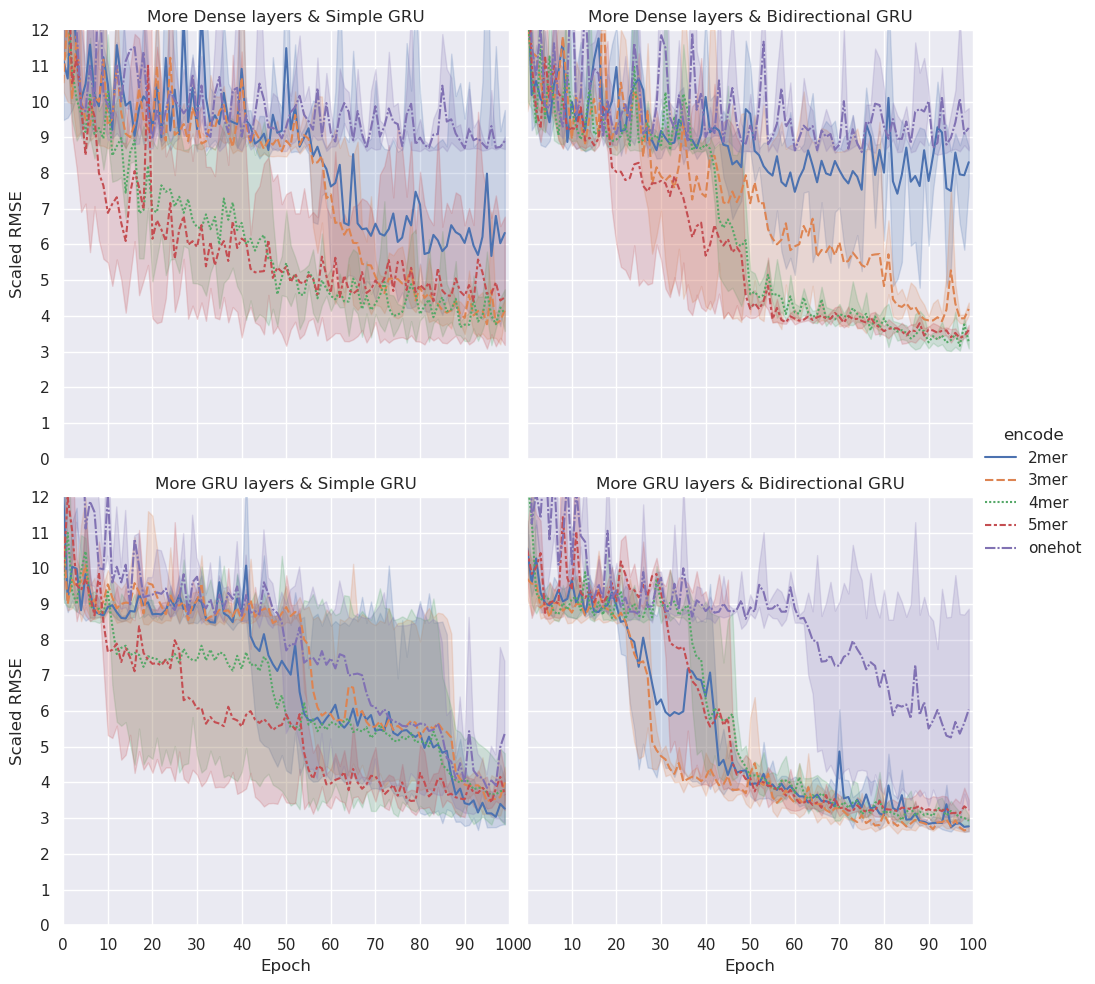

In [96]:
facet = plot_setting_2("./logs/ce_no_spike/", "validation", "epoch_s_rmse")
plt.savefig(f"./plots/comparisons_valid_ce_no_spike_2.png")
plt.show()

In [72]:
df_all = pd.DataFrame()
row_index = 0
for setting in (1, 2, 3, 4):
    for seed in (1, 42, 100):
        seed_path = Path(f"./logs/ce_no_spike/setting_{setting}/seed_{seed}")
        for model_path in seed_path.glob("*_model"):
            model_name = model_path.stem
            event_dir = model_path / "info"
            event_path_list = list(event_dir.glob("events.out.tfevents.*"))
            for event_path in event_path_list:
                if "training_time" in get_tags(event_path):
                    break
            time = extract_text_by_tag(event_path, "training_time")
            h, m, s = time.split(":")
            df_all.loc[row_index, "encode"] = model_name.split("_")[0]
            df_all.loc[row_index, "setting"] = setting
            # df_all.loc[row_index, "seed"] = seed
            df_all.loc[row_index, "seconds"] = int(h) * 60 * 60 + int(m) * 60 + float(s)
            row_index += 1
mean_time = df_all.groupby(["encode", "setting"]).mean()
mean_time.reset_index(inplace=True)
mean_time["time"] = pd.to_datetime(mean_time["seconds"], unit="s").dt.strftime("%M:%S")
mean_time.to_csv("./logs/ce_no_spike/time.tsv", sep="\t", index=False)

### Normalization

In [104]:
log_path_dict = {
    "none": "./logs/ce_no_spike/setting_2/seed_42/5mer_model",
    # "none": "./logs/normalization_test/none_setting_2/5mer_model",
    "LN": "./logs/normalization_test/ln_inside_setting_2/5mer_model"
}
df_all = pd.DataFrame()
for norm, log_path in log_path_dict.items():
    for dataset in ("train", "validation"):
        event_dir = Path(log_path) / dataset
        event_path = get_event_path(event_dir)
        df_temp = event_to_df(event_path, "epoch_s_rmse")
        df_temp["dataset"] = dataset
        df_temp["normalization"] = norm
        df_temp["wall_time"] -= df_temp.loc[0, "wall_time"]
        df_all = pd.concat([df_all, df_temp])
df_all.head()

,wall_time,step,epoch_s_rmse,dataset,normalization
0,0.000000,0,149.670883,train,none
1,6.345990,1,12.672016,train,none
2,12.615780,2,11.052293,train,none
3,18.903356,3,10.128158,train,none
4,25.152404,4,10.718190,train,none


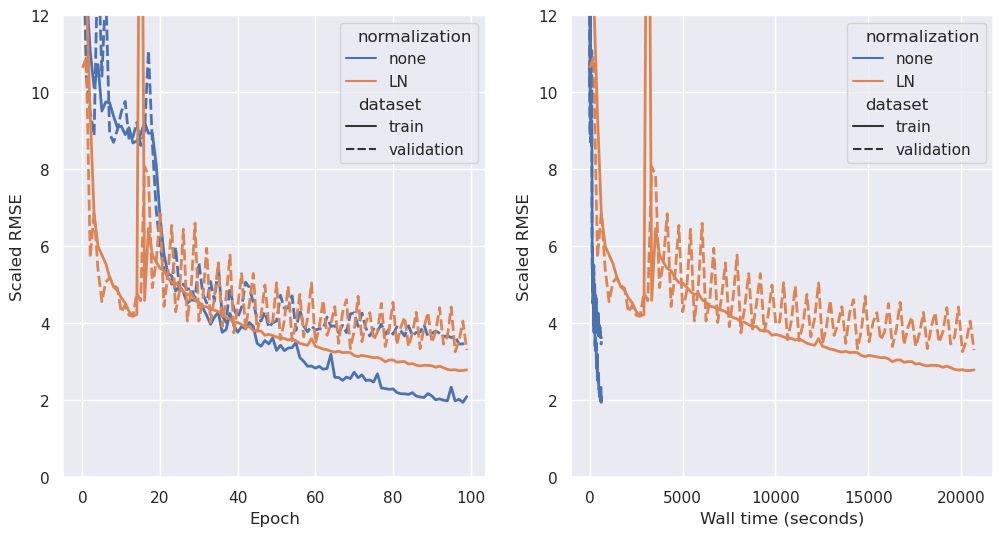

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = sns.lineplot(
    data=df_all, x="step", y="epoch_s_rmse", 
    hue="normalization", style="dataset", lw=2,
    ax=axes[0]
)
ax.set(
    xlabel="Epoch",
    ylabel="Scaled RMSE", ylim=(0, 12)
)
ax = sns.lineplot(
    data=df_all, x="wall_time", y="epoch_s_rmse", 
    hue="normalization", style="dataset", lw=2,
    ax=axes[1]
)
ax.set(
    xlabel="Wall time (seconds)",
    ylabel="Scaled RMSE", ylim=(0, 12)
)
plt.savefig("./plots/standard_gru_ln.png")
plt.show()

In [113]:
log_path_dict = {
    "none": "./logs/ce_no_spike/setting_4/seed_42",
    "LN on GRU's output": "./logs/normalization_test/ln_outside_setting_4",
    "LN on dense layers": "./logs/normalization_test/ln_dense_setting_4"
}
df_all = pd.DataFrame()
for norm, log_path in log_path_dict.items():
    for dataset in ("train", "validation"):
        for encode in ("3mer", "4mer", "5mer"):
            event_dir = Path(log_path) / f"{encode}_model" / dataset
            event_path = get_event_path(event_dir)
            df_temp = event_to_df(event_path, "epoch_s_rmse")
            df_temp["encode"] = encode
            df_temp["dataset"] = dataset
            df_temp["normalization"] = norm
            df_all = pd.concat([df_all, df_temp])
df_all.head()

,wall_time,step,epoch_s_rmse,encode,dataset,normalization
0,1.687561e+09,0,63.859623,3mer,train,none
1,1.687561e+09,1,10.767700,3mer,train,none
2,1.687561e+09,2,9.931134,3mer,train,none
3,1.687561e+09,3,9.906119,3mer,train,none
4,1.687561e+09,4,9.363079,3mer,train,none


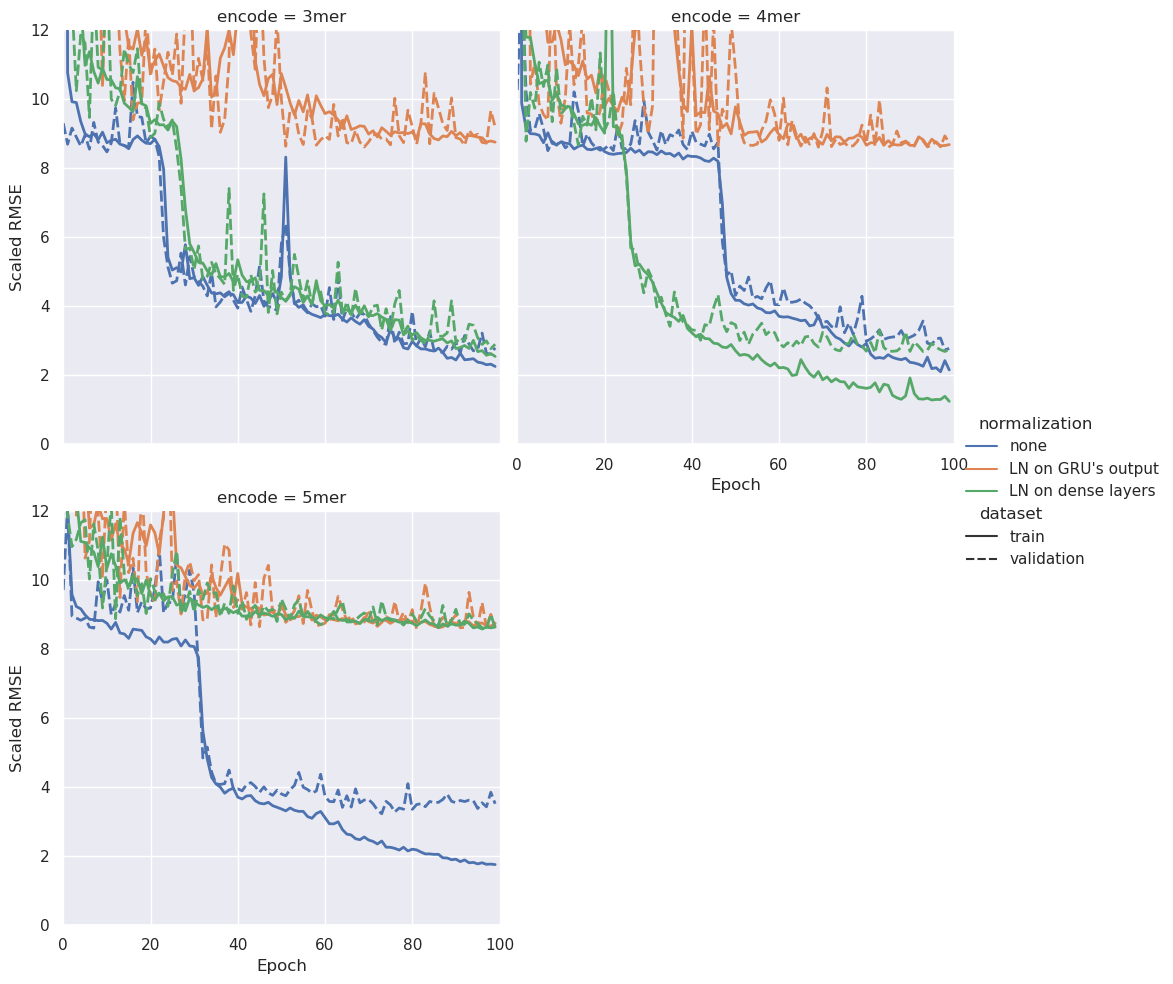

In [114]:
facet = sns.relplot(
    data=df_all, x="step", y="epoch_s_rmse", 
    hue="normalization", style="dataset", 
    col="encode", col_wrap=2,
    kind="line", lw=2
)
facet.set(
    xlim=(0, 100), xlabel="Epoch",
    ylim=(0, 12), ylabel="Scaled RMSE"
)
# plt.tight_layout()
# plt.savefig("./plots/other_ln.png")
plt.show()

In [124]:
df_all = pd.DataFrame()
for setting in (2, 4):
    for dataset in ("train", "validation"):
        for encode in ("3mer", "4mer", "5mer"):
            bn_log_path = Path(f"./logs/normalization_test/bn_setting_{setting}/{encode}_model/{dataset}")
            none_log_path = Path(f"./logs/ce_no_spike/setting_{setting}/seed_42/{encode}_model/{dataset}")
            bn_event_path = get_event_path(bn_log_path)
            none_event_path = get_event_path(none_log_path)
            df_bn = event_to_df(bn_event_path, "epoch_s_rmse")
            df_bn["setting"] = setting
            df_bn["encode"] = encode
            df_bn["dataset"] = dataset
            df_bn["normalization"] = "BN"
            df_none = event_to_df(none_event_path, "epoch_s_rmse")
            df_none["setting"] = setting
            df_none["encode"] = encode
            df_none["dataset"] = dataset
            df_none["normalization"] = "none"
            df_all = pd.concat([df_all, df_none, df_bn])
df_all.head()

,wall_time,step,epoch_s_rmse,setting,encode,dataset,normalization
0,1.687550e+09,0,73.651787,2,3mer,train,none
1,1.687550e+09,1,10.383167,2,3mer,train,none
2,1.687550e+09,2,11.723974,2,3mer,train,none
3,1.687550e+09,3,10.464757,2,3mer,train,none
4,1.687550e+09,4,10.978290,2,3mer,train,none


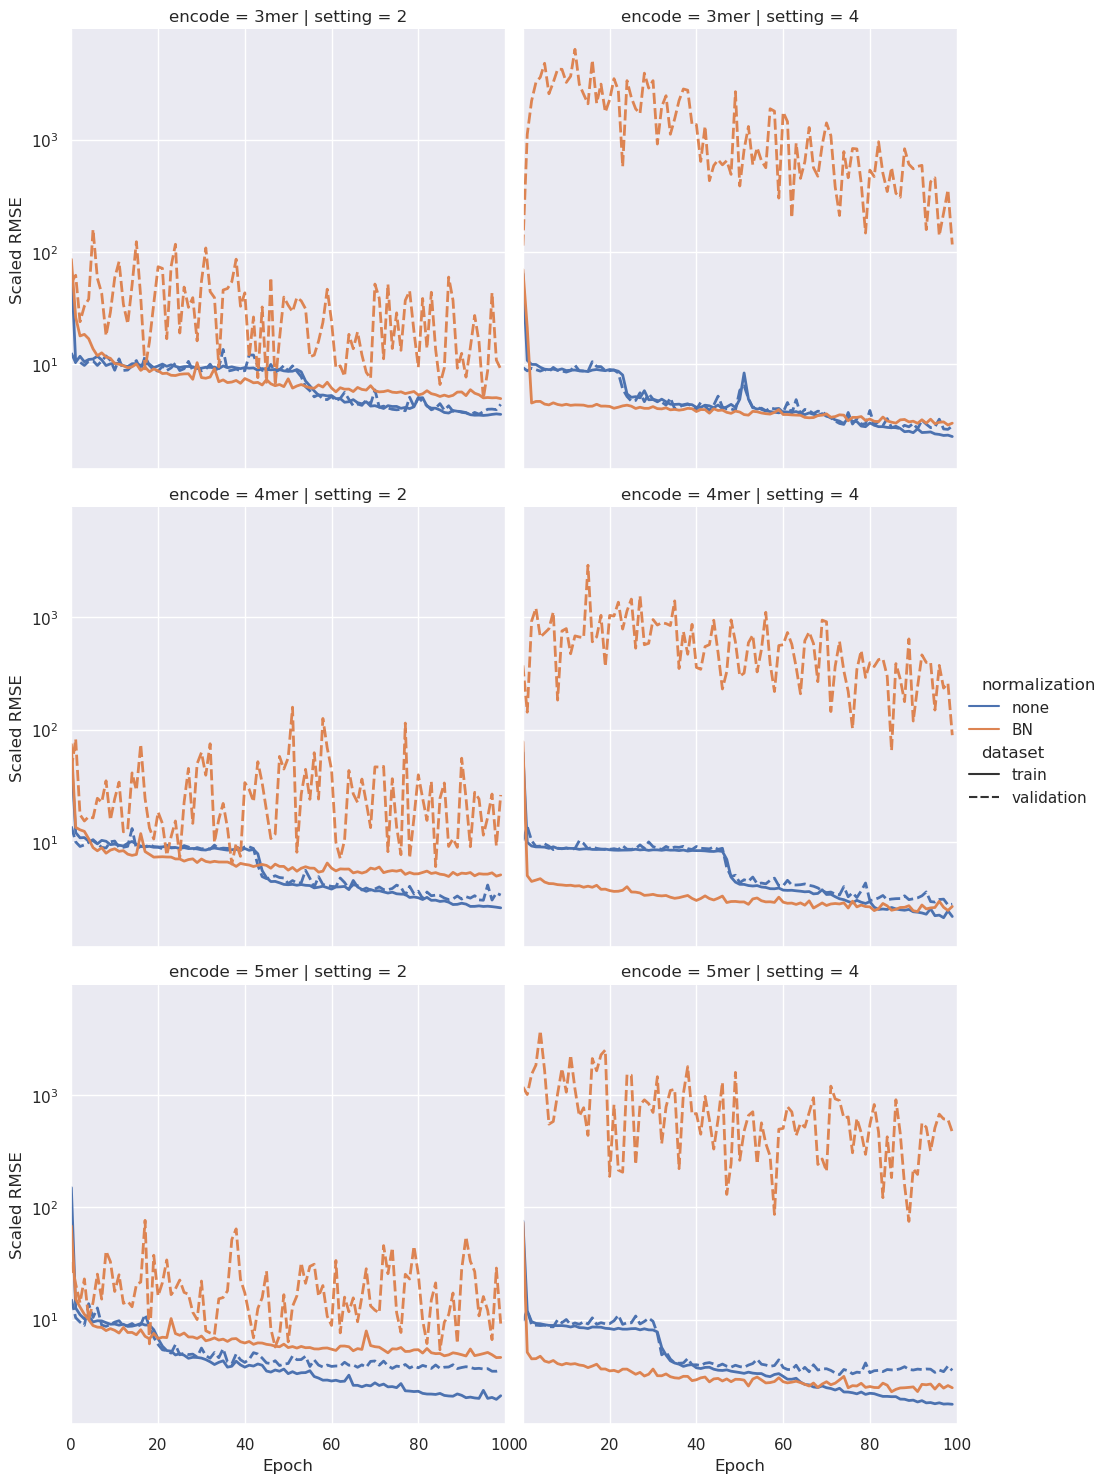

In [125]:
facet = sns.relplot(
    data=df_all, x="step", y="epoch_s_rmse", 
    hue="normalization", style="dataset", 
    col="setting", row="encode",
    kind="line", lw=2
)
facet.set(
    xlim=(0, 100), xlabel="Epoch",
    yscale="log", ylabel="Scaled RMSE"
)
# plt.tight_layout()
plt.savefig("./plots/bn.png")
plt.show()

### Learning rate schedule

In [21]:
def aggregate_lr_results(lr_path, data_type, tag):
    assert data_type in ("lr", "train", "validation")
    df_all = pd.DataFrame()
    schedule_names = {
        "constant": "constant", 
        "cos_decay_2": "cosine decay", 
        "cos_restart_4": "cosine decay restart", 
        "exp_decay": "exponential decay", 
        "one_cycle": "one cycle"
    }
    for setting in (5, 6):
        for schedule in schedule_names:
            schedule_path = lr_path / f"{schedule}_s{setting}"
            for kmer_path in schedule_path.glob("*mer"):
                kmer_name = kmer_path.stem
                event_dir = kmer_path / data_type
                event_path = get_event_path(event_dir)
                df_temp = event_to_df(event_path, tag)
                df_temp["encode"] = kmer_name
                df_temp["schedule"] = schedule_names[schedule]
                df_temp["setting"] = setting
                df_all = pd.concat([df_all, df_temp])
    return df_all

# lr_main_path = Path("./logs/lr_schedule")
# df_lr = aggregate_lr_results(lr_main_path, "lr", "learning_rate")
# df_lr.to_csv(lr_main_path / "lr.csv")
# df_train = aggregate_lr_results(lr_main_path, "train", "epoch_s_rmse")
# df_train.to_csv(lr_main_path / "train_rmse.csv")
# df_valid = aggregate_lr_results(lr_main_path, "validation", "epoch_s_rmse")
# df_valid.to_csv(lr_main_path / "valid_rmse.csv")

In [29]:
# df_lr = pd.read_csv("./logs/lr_schedule/lr.csv")
# df_lr_plot = df_lr[(df_lr["encode"] == "3mer") & (df_lr["setting"] == 5)]
# df_lr_plot.drop(["encode", "setting"], axis=1, inplace=True)
# df_lr_plot.to_csv(lr_main_path / "lr_plot.csv")

/tmp/ipykernel_890041/1608677787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr_plot.drop(["encode", "setting"], axis=1, inplace=True)


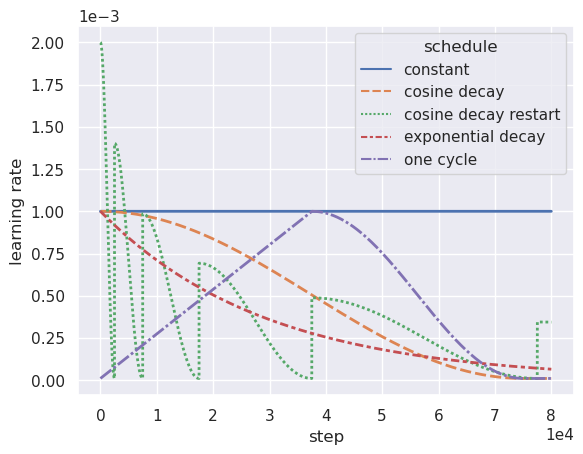

In [70]:
df_lr_plot = pd.read_csv("./logs/lr_schedule/lr_plot.csv")
ax = sns.lineplot(
    data=df_lr_plot, x="step", y="learning_rate", 
    hue="schedule", style="schedule", lw=2
)
ax.set(ylabel="learning rate")
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
plt.savefig("./plots/lr_shcedule.png")
plt.show()

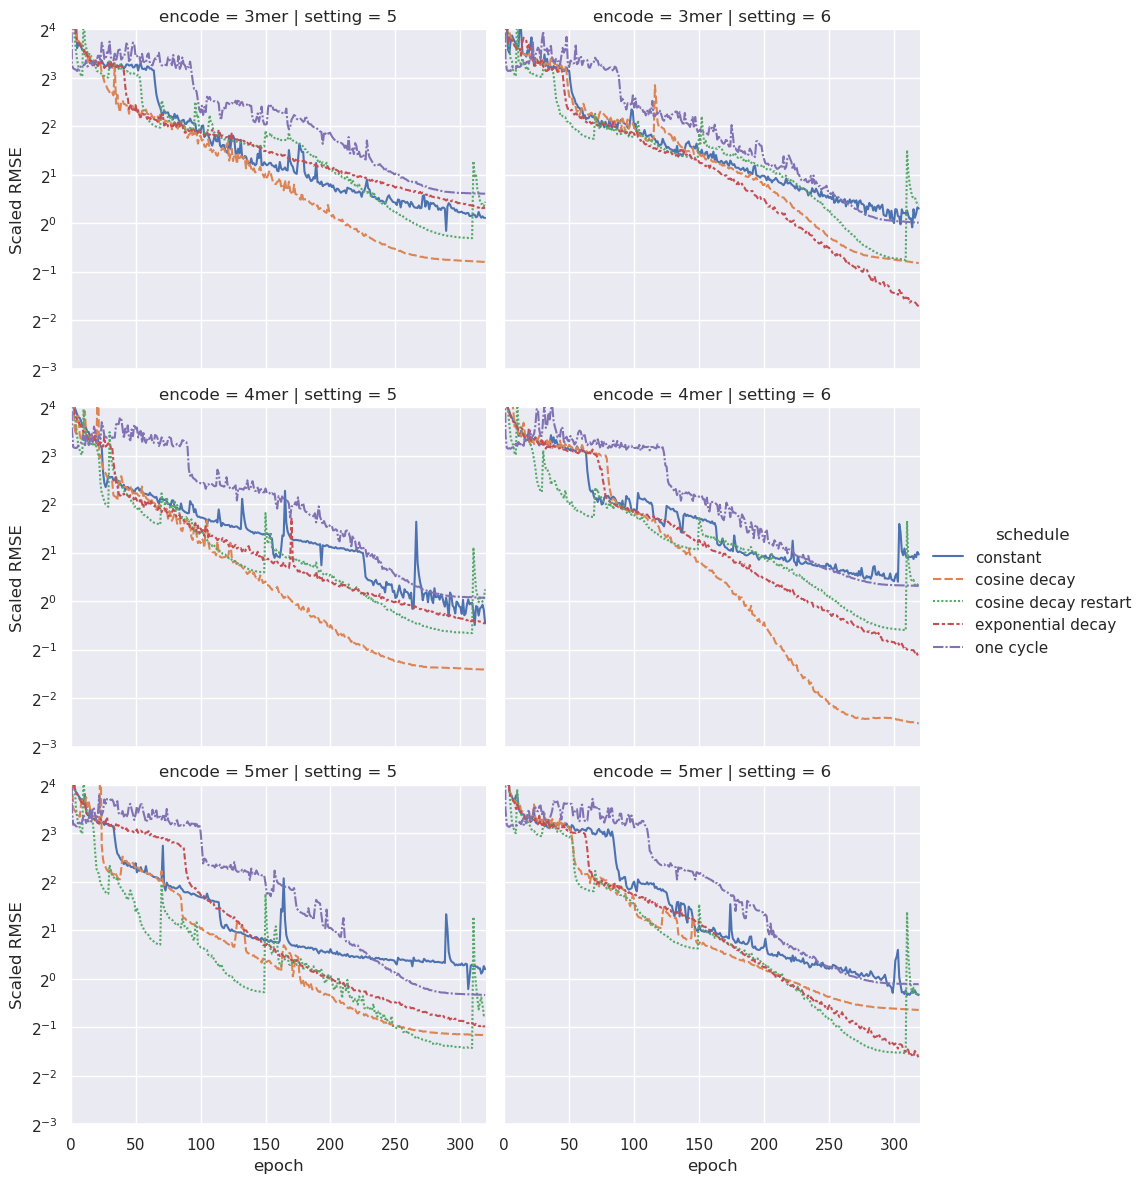

In [61]:
df_train = pd.read_csv("./logs/lr_schedule/train_rmse.csv")
facet = sns.relplot(
    data=df_train, x="step", y="epoch_s_rmse", 
    hue="schedule", style="schedule",
    row="encode", row_order=["3mer", "4mer", "5mer"],
    col="setting", col_order=[5, 6],
    kind="line", height=4, aspect=1.2
)
facet.set(
    xlim=(0, 320), xlabel="epoch",
    ylim=(0.125, 16), ylabel="Scaled RMSE"
)
plt.yscale("log", base=2)
# plt.savefig("./plots/lr_schedule_train")
plt.show()

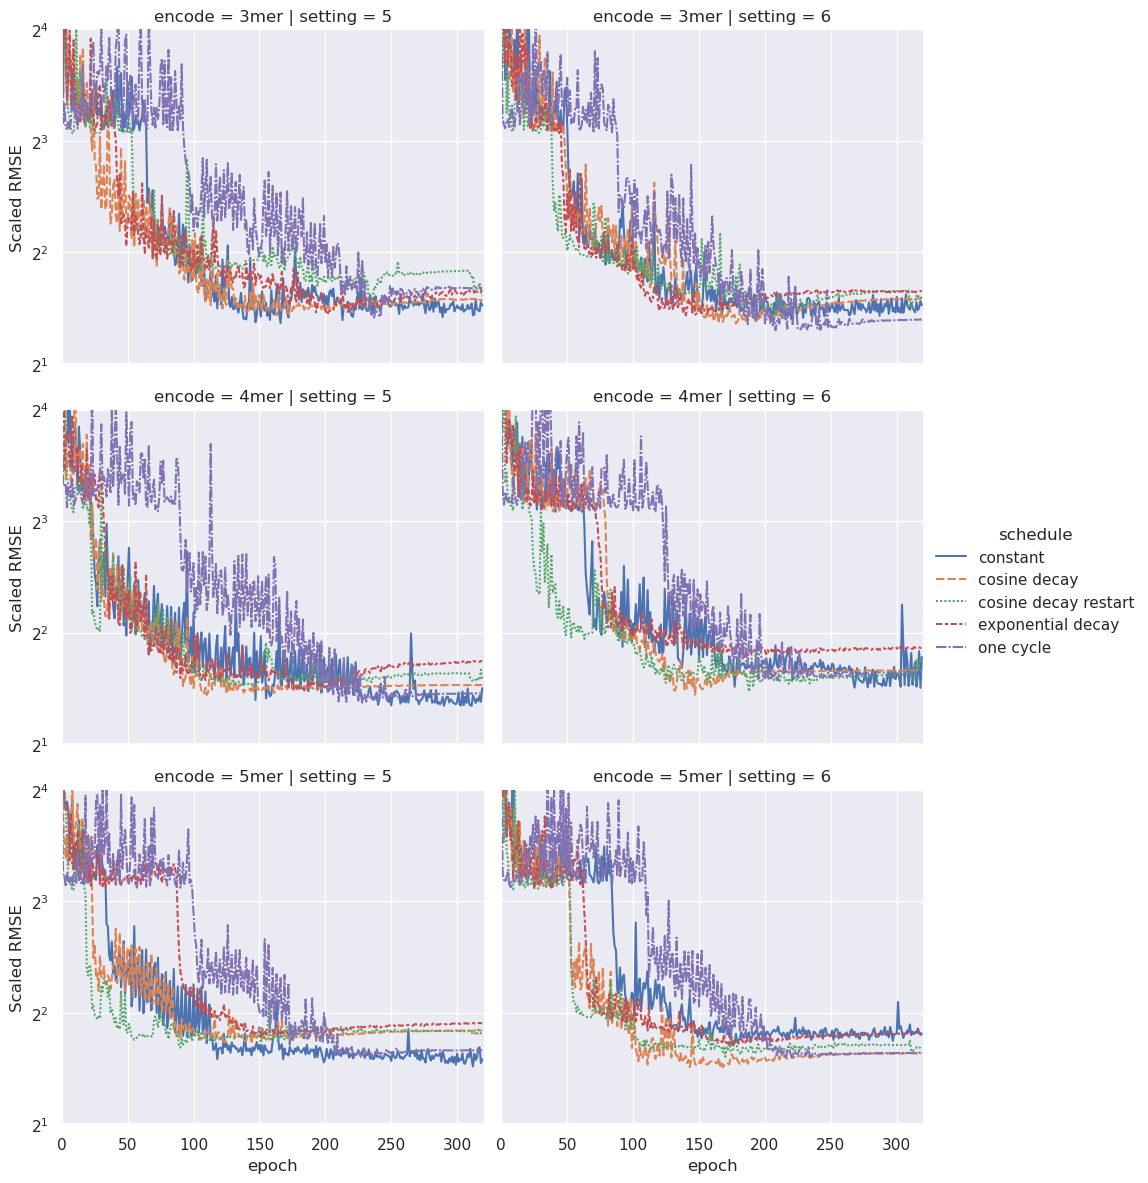

In [62]:
df_valid = pd.read_csv("./logs/lr_schedule/valid_rmse.csv", index_col=0)
facet = sns.relplot(
    data=df_valid, x="step", y="epoch_s_rmse", 
    hue="schedule", style="schedule",
    row="encode", row_order=["3mer", "4mer", "5mer"],
    col="setting", col_order=[5, 6],
    kind="line", height=4, aspect=1.2
)
facet.set(
    xlim=(0, 320), xlabel="epoch",
    ylim=(2, 16), ylabel="Scaled RMSE"
)
plt.yscale("log", base=2)
# plt.savefig("./plots/lr_schedule_valid")
plt.show()

### hyperband

In [2]:
def calculate_HB_run_info(max_epoch, factor, est_epoch_time=30):
    df = pd.DataFrame()
    s_max = floor(log(max_epoch, factor))
    s_b = ceil(log(max_epoch, factor)) + 1
    total_trial = 0
    total_epoch = 0
    for s in range(s_max, -1, -1):
        for i in range(s + 1):
            n = ceil(s_b / (s + 1) * factor ** (s - i))
            r = ceil(max_epoch / factor ** (s - i))
            df.loc[i, f"n_{s}"] = n
            df.loc[i, f"r_{s}"] = r
            if i == 0:
                total_trial += n
            if 0 < i <= s:
                total_epoch += (df.loc[i-1, f"n_{s}"] - n) * df.loc[i-1, f"r_{s}"]
        total_epoch += n * r
    estimated_time = total_epoch * est_epoch_time
    time_obj = datetime.timedelta(seconds=estimated_time)
    time_str = str(time_obj)
    
    display(df)
    print(f"total trial: {total_trial}")
    print(f"total epoch: {total_epoch}")
    print(f"estimated time: {time_str}")
    return df, total_trial, total_epoch

In [7]:
df, total_trial, total_epoch = calculate_HB_run_info(320, 6, est_epoch_time=60)

,n_3,r_3,n_2,r_2,n_1,r_1,n_0,r_0
0,270.0,2.0,60.0,9.0,15.0,54.0,5.0,320.0
1,45.0,9.0,10.0,54.0,3.0,320.0,NaN,NaN
2,8.0,54.0,2.0,320.0,NaN,NaN,NaN,NaN
3,2.0,320.0,NaN,NaN,NaN,NaN,NaN,NaN


total trial: 350
total epoch: 6477.0
estimated time: 4 days, 11:57:00


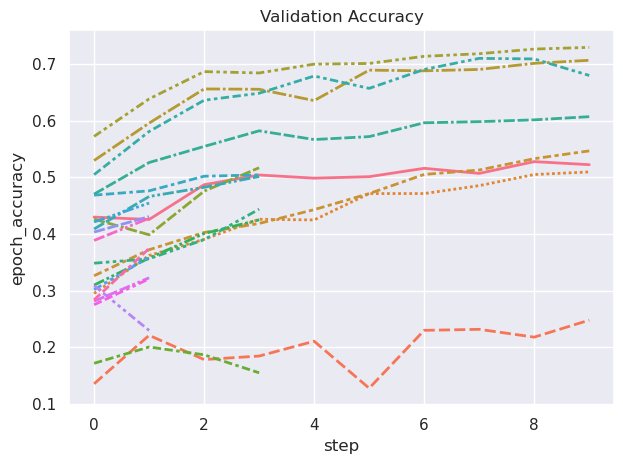

In [54]:
class HBProject:
    def __init__(self, tuner_dir, project_name):
        self.tuner_dir = Path(tuner_dir) if isinstance(tuner_dir, str) else tuner_dir
        self.project_dir = self.tuner_dir / project_name / project_name
        self.tb_dir = self.tuner_dir / project_name / "tb_logs"
        self.trials = self.to_df()
        
        proj_json = self.project_dir / "oracle.json"
        with proj_json.open() as f:
            state = json.load(f)
        config_keys = ["max_epochs", "factor", "hyperband_iterations", "seed"]
        self.config = {key: state[key] for key in config_keys}
        
    def to_df(self):
        df_all = pd.DataFrame()
        for i, trial_dir in enumerate(self.project_dir.glob("trial_*")):
            trial_json = trial_dir / "trial.json"
            with trial_json.open() as f:
                trial_dict = json.load(f)
            values = trial_dict["hyperparameters"]["values"]
            trial_id = trial_dict["trial_id"]
            df_new = pd.DataFrame(values, index=[int(trial_id)])
            df_new["trial_id"] = trial_id
            df_all = pd.concat([df_all, df_new])
        cols = ["trial_id", "tuner/trial_id", "tuner/bracket", "tuner/round", "tuner/epochs", "tuner/initial_epoch", ]
        cols.extend(df_all.drop(cols, axis=1).columns.tolist())
        return df_all.sort_index()[cols]
    
    def run_info(self):
        df_run = pd.DataFrame()
        df = self.trials
        s_max = df.loc[0, "tuner/bracket"]
        for s in range(s_max, -1, -1):
            for i in range(s + 1):
                df_subset = df[(df["tuner/bracket"] == s) & (df["tuner/round"] == i)]
                df_run.loc[i, f"n_{s}"] = df_subset.shape[0]
                df_run.loc[i, f"r_{s}"] = df_subset.iloc[0, 4]
        return df_run
    
    def plot(self, data_type, tag, **plot_args):
        df = self.trials

        group_list = []
        skip_row = []
        for i in df.index[::-1]:
            if i in skip_row:
                continue
            new_group = [df.loc[i, "trial_id"]]
            last_trial = df.loc[i, "tuner/trial_id"]
            while pd.notna(last_trial):
                skip_row.append(int(last_trial))
                new_group.append(last_trial)
                last_trial = df.loc[int(last_trial), "tuner/trial_id"]
            group_list.append(new_group)

        df_all = pd.DataFrame()
        for group in group_list:
            df_group = pd.DataFrame()
            for trial in group:
                event_path = get_event_path(self.tb_dir / trial / "execution0" / data_type)
                df_new = event_to_df(event_path, tag)
                df_group = pd.concat([df_group, df_new])
            df_group["trial_id"] = "_".join(group)
            df_all = pd.concat([df_all, df_group])

        return sns.lineplot(data=df_all, x="step", y=tag, hue="trial_id", style="trial_id", **plot_args)

proj = HBProject("./tune", "cnn_test_R10_n3")
ax = proj.plot("validation", "epoch_accuracy", lw=2)
ax.set_title("Validation Accuracy")
sns.move_legend(ax, loc="upper center", ncols=3)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

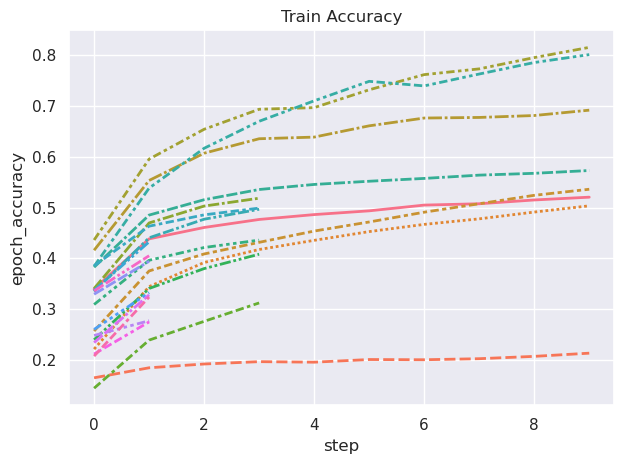

In [221]:
ax = proj.plot("train", "epoch_accuracy", lw=2)
ax.set_title("Train Accuracy")
sns.move_legend(ax, loc="upper center", ncols=3)
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

In [151]:
proj.run_info()

,n_2,r_2,n_1,r_1,n_0,r_0
0,12.0,2.0,6.0,4.0,4.0,10.0
1,4.0,4.0,2.0,10.0,NaN,NaN
2,2.0,10.0,NaN,NaN,NaN,NaN


In [152]:
proj.config

{'max_epochs': 10, 'factor': 3, 'hyperband_iterations': 1, 'seed': 42}

In [55]:
proj = HBProject("./tune", "final_2")
proj.trials

,trial_id,tuner/trial_id,tuner/bracket,tuner/round,tuner/epochs,tuner/initial_epoch,kmer_choice,embed_dim,gru_num,gru_unit,gru_dropout_rate,total_layer_num,dense_unit,leaky_alpha,dense_dropout_rate,train_batch_size,lr_schedule,weight_decay
0,0000,NaN,4,0,2,0,4mer,32,4,64,0.5,13,256,0.00,0.3,8,cos_decay,0.001
1,0001,NaN,4,0,2,0,3mer,512,6,512,0.1,20,64,0.25,0.2,16,cos_decay,0.030
2,0002,NaN,4,0,2,0,4mer,128,4,32,0.1,18,512,0.40,0.2,8,cos_decay,0.030
3,0003,NaN,4,0,2,0,4mer,64,7,512,0.1,12,256,0.05,0.3,32,cos_decay,0.030
4,0004,NaN,4,0,2,0,3mer,64,2,64,0.1,14,1024,0.20,0.4,16,cos_decay,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0401,0326,4,2,20,5,5mer,512,2,128,0.1,13,128,0.20,0.4,8,exp_decay,0.001
402,0402,0313,4,2,20,5,3mer,32,5,32,0.4,15,64,0.05,0.2,8,cos_decay,0.001
403,0403,0369,4,2,20,5,3mer,64,4,512,0.1,20,64,0.40,0.3,8,exp_decay,0.003
404,0404,0347,4,2,20,5,4mer,64,4,128,0.2,13,64,0.20,0.2,64,cos_decay,0.001


In [59]:
proj.trials.loc[317]

trial_id                    0317
tuner/trial_id              0278
tuner/bracket                  4
tuner/round                    1
tuner/epochs                   5
tuner/initial_epoch            2
kmer_choice                 5mer
embed_dim                    256
gru_num                        6
gru_unit                     256
gru_dropout_rate             0.4
total_layer_num               11
dense_unit                    64
leaky_alpha                  0.2
dense_dropout_rate           0.5
train_batch_size               8
lr_schedule            cos_decay
weight_decay               0.001
Name: 317, dtype: object